In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn as nn

Using GPU instead of CPU

In [4]:
if torch.backends.mps.is_available():
    device = "mps" 
    print("mps is available. GPU can be used with PyTorch on Apple Silicon.")
    
    # Optionally, you can get the MPS device name
    mps_device = torch.device("mps")
    print(f"Using device: {mps_device}")
else:
    device = "cpu"
    print("mps is not available. GPU cannot be used with PyTorch on Apple Silicon.")

mps is available. GPU can be used with PyTorch on Apple Silicon.
Using device: mps


File path for train and test dataset

In [5]:
import requests
import zipfile
from pathlib import Path
import os

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


def walk_through_dir(dir_path):
    """walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

train_dir = image_path / "train"
test_dir = image_path/ "test"

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Visualising an image

pizza
Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


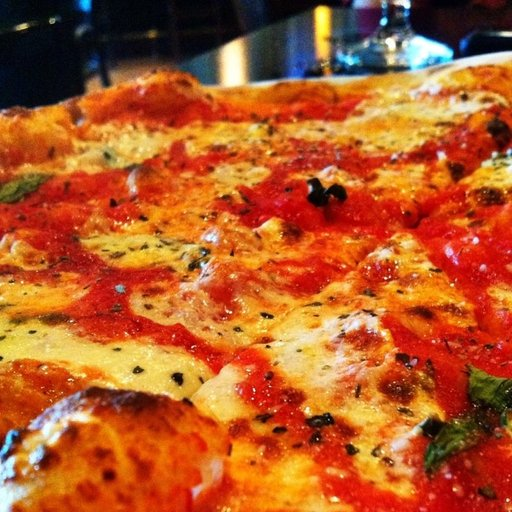

In [6]:
#visualising  an image
import random
from PIL import Image

random.seed(42)         #if want to change the image need remove this random seed and run agn

#get all the imgae paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random imgae
random_image_path = random.choice(image_path_list)
random_image_path

#get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

#open image
img = Image.open(random_image_path)

#print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

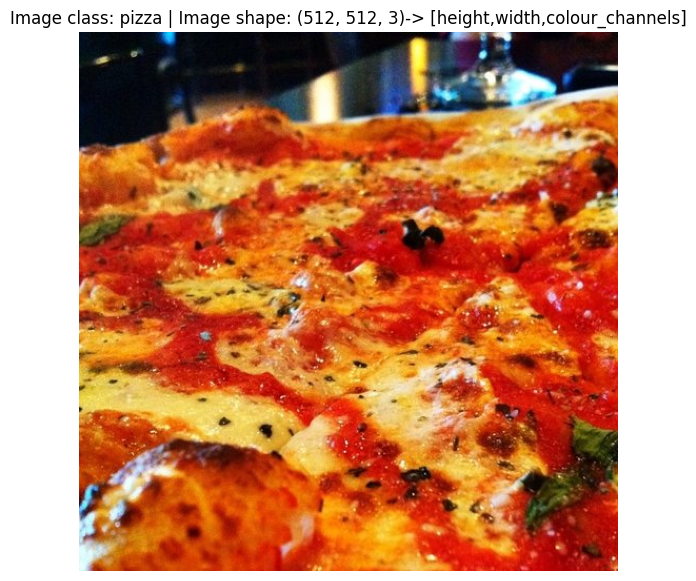

In [7]:
# try to visualise an image with matplotlib
import matplotlib.pyplot as plt

#turn image into an array
img_as_array = np.asarray(img)

#plto the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}-> [height,width,colour_channels]")
plt.axis(False)

Transforming the data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#write a transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),            #resize the images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),         #flip tge images randomly on the horizontal
    transforms.ToTensor()     #turn the image into a torch tensor

])

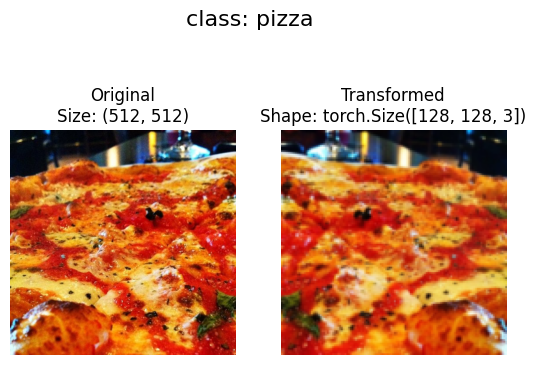

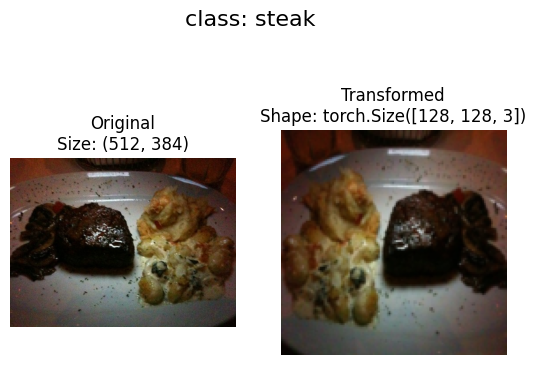

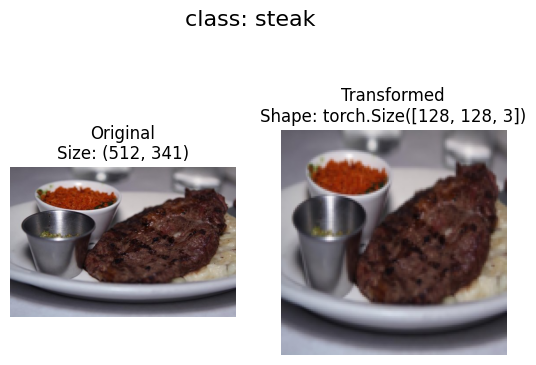

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """selects random imgaes from a path of images and loads/transforms them
    then place the original vs the transformed version"""
    if seed:
        random.seed(42)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols =2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            #transform and plot the target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"class: {image_path.parent.stem}",fontsize = 16)

plot_transformed_images(image_paths =image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

Loading imgae data using 'ImageFolder'

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root= train_dir,
                                  transform=data_transform,         #transform for the data
                                  target_transform=None)            #transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

Identify the class names

In [12]:
#get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

Train and test dataset sizes

In [13]:
#check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

original shape: torch.Size([3, 128, 128])->[c,h,w]
Image permute: torch.Size([128, 128, 3])->[h,w,c]


Text(0.5, 1.0, 'pizza')

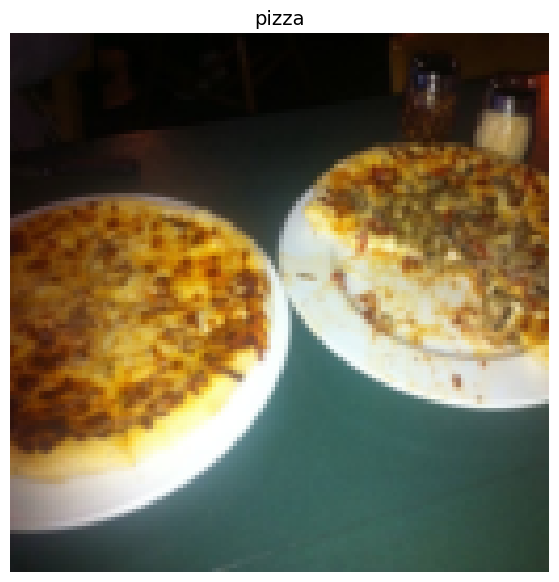

In [ ]:
img, label =train_data[0][0],train_data[0][1]

#rearrange the order dimensions 
img_permute = img.permute(1,2,0) 

#print out differenet shapes
print(f"original shape: {img.shape}->[c,h,w]")
print(f'Image permute: {img_permute.shape}->[h,w,c]')

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize = 14)

Turning dataset into dataloaders

In [16]:
os.cpu_count()      #number of cpu cores

#turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)


In [18]:
len(train_dataloader), len(test_dataloader)     #number of batches in the dataloaders

(8, 3)

In [20]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}-> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128])-> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


TinyResNet Model

In [22]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class TinyResNet128(nn.Module):
    def __init__(self, input_shape=3, num_classes=3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size=3, padding=1),  # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 64x64
        )

        self.res1 = ResidualBlock(32, 64, downsample=True)   # 64x64 → 32x32
        self.res2 = ResidualBlock(64, 128, downsample=True)  # 32x32 → 16x16
        self.res3 = ResidualBlock(128, 128, downsample=True) # 16x16 → 8x8
        self.res4 = ResidualBlock(128, 128)                  # 8x8 → 8x8

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # → 1x1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [24]:
model_0 = TinyResNet128(input_shape=3,
                        num_classes=len(class_names)).to(device)
#check the model    
#model_0

In [26]:
#transforms.Resize((128, 128))

Prepping the data for training and testing

In [27]:
#creating transforms and loading data for model 0
simple_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                       transforms.ToTensor()])

#1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

#2. turn the datasets into Dataloaders
import os
from torch.utils.data import DataLoader

#setup batch size and number of works
BATCH_SZIE = 32
NUM_WORKERS = os.cpu_count()

# create Dataloader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SZIE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True
                                     )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SZIE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)



In [28]:
#passing dummy data throught the model
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [29]:
#try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.1834, -0.1734,  0.1237],
        [ 0.0816,  0.2200, -0.0524],
        [-0.0912,  0.5863,  0.0515],
        [-0.0408, -0.0192,  0.1620],
        [ 0.0250,  0.2226,  0.4796],
        [-0.3117,  0.5029,  0.2710],
        [ 0.1320,  0.1119,  0.1185],
        [-0.1731,  0.3049,  0.3300],
        [ 0.1266,  0.4381,  0.6159],
        [-0.0159,  0.0760,  0.5054],
        [-0.1074,  0.1722,  0.2579],
        [-0.0177,  0.1648,  0.4756],
        [-0.4273, -0.2397,  0.5791],
        [ 0.3390,  0.0346,  0.3575],
        [-0.1472,  0.4656,  0.4128],
        [ 0.2703,  0.2405,  0.2049],
        [-0.0682,  0.1892,  0.3685],
        [-0.3904,  0.4374,  0.0996],
        [ 0.0404,  0.0304,  0.1434],
        [-0.0368,  0.2404, -0.0107],
        [-0.3015,  0.3909,  0.2769],
        [ 0.0020,  0.2531,  0.2208],
        [ 0.2397,  0.0756,  0.1759],
        [-0.5589,  0.3783,  0.4880],
        [-0.4498,  0.2176,  0.2903],
        [-0.1522,  0.5237,  0.4086],
        [ 0.1078,  0.0956,  0.5618],
 

In [31]:
from torchinfo import summary
summary(model=model_0,
        input_size=[1,3,128,128])         #need to be the correct input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyResNet128                            [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 128]         64
│    └─ReLU: 2-3                         [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-4                    [1, 32, 64, 64]           --
├─ResidualBlock: 1-2                     [1, 64, 32, 32]           --
│    └─Sequential: 2-5                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           2,112
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    └─Conv2d: 2-6                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-7                  [1, 64, 32, 32]           128
│    └─Conv2d: 2-8                       [1, 64, 32, 32]           36,928
│

train_step()

In [32]:
#create train_step()

import torch.utils
import torch.utils.data


def train_step(model:nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    model.train()

    #setup train loss and train accuracy values
    train_loss, train_acc = 0,0
    
    #loop through data loader data batches
    for batch,(x,y) in enumerate(dataloader):
        #send data to the target device
        x, y = x.to(device), y.to(device)

        #1. forward pass
        y_pred = model(x)

        #2. calculate the loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        #3. optimizer zero grad
        optimizer.zero_grad()

        #4. loss backward
        loss.backward()

        #5. optimizer step
        optimizer.step()

        #calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    #adjust metric to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc



test_step()

In [33]:
# create a test step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    test_loss, test_acc = 0,0

    # turn on inference mode
    with torch.inference_mode():
        # loop through Dataloader batches
        for batch, (x,y) in enumerate (dataloader):
            # send data to the target device
            x, y = x.to(device), y.to(device)

            # 1. forward pass
            test_pred_logits = model(x)


            # 2. calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
        #learning rate scheduler?
        #adjust metrics to get avrage loss and accuracy per batch
        test_loss = test_loss/len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc


Training function

In [45]:
from tqdm.auto import tqdm

# 1. creata a train fn that takes in various model parameters + optimizer +lossfn
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          device= device):
    
    best_loss = float('inf')
    best_acc = 0
    patience = 5
    trigger_times = 0
    early_stop = False
    
    # create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}
    
    # lopp through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        scheduler.step(test_loss)
        # print out whats happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        # Option 1: Monitor test_loss
        if test_loss < best_loss:
            best_loss = test_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ Saved new best model at epoch {epoch+1} with loss: {test_loss:.4f}")
        else:
            trigger_times += 1
            print(f"⚠️ No improvement in loss for {trigger_times} epoch(s)")
            if trigger_times >= patience:
                print("⛔ Early stopping triggered.")
                early_stop = True
                break

    # return the filled reulsts at the end of the epoch
    return results


Training model_0

In [46]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop(128, scale=(0.85, 1.0)),  # slight zoom/shift
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [47]:
train_dataset_augmented = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

In [48]:
# train and evulate model 0
torch.manual_seed(42)

# set the number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyResNet128(input_shape=3,      #number of colour channels
                        num_classes=len(class_names)).to(device)

# setup loss fn and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1) #label smoothing is a regularization technique that helps to prevent overfitting 
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # we're tracking validation loss
    factor=0.5,       # reduce LR by half
    patience=2,       # wait 2 epochs before reducing
    verbose=True      # prints when LR is reduced
)


# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        scheduler=scheduler,
                        device=device,
                        epochs=NUM_EPOCHS)

# end the timer
end_time = timer()
print(f"total training time: {end_time-start_time:.3f} seconds")



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  5%|▌         | 1/20 [00:18<05:56, 18.75s/it]

Epoch: 0 | Train loss: 1.1034 | Train acc: 0.3242 | Test loss: 1.0972 | Test acc: 0.2604
✅ Saved new best model at epoch 1 with loss: 1.0972


 10%|█         | 2/20 [00:37<05:33, 18.55s/it]

Epoch: 1 | Train loss: 1.0369 | Train acc: 0.4648 | Test loss: 1.1024 | Test acc: 0.2708
⚠️ No improvement in loss for 1 epoch(s)


 15%|█▌        | 3/20 [00:55<05:13, 18.44s/it]

Epoch: 2 | Train loss: 0.9541 | Train acc: 0.5195 | Test loss: 1.1060 | Test acc: 0.2917
⚠️ No improvement in loss for 2 epoch(s)


 20%|██        | 4/20 [01:13<04:53, 18.37s/it]

Epoch: 3 | Train loss: 0.9746 | Train acc: 0.5859 | Test loss: 1.0796 | Test acc: 0.3116
✅ Saved new best model at epoch 4 with loss: 1.0796


 25%|██▌       | 5/20 [01:32<04:36, 18.43s/it]

Epoch: 4 | Train loss: 0.9268 | Train acc: 0.6016 | Test loss: 1.0828 | Test acc: 0.3920
⚠️ No improvement in loss for 1 epoch(s)


 30%|███       | 6/20 [01:50<04:17, 18.42s/it]

Epoch: 5 | Train loss: 0.8405 | Train acc: 0.5977 | Test loss: 1.0450 | Test acc: 0.4025
✅ Saved new best model at epoch 6 with loss: 1.0450


 35%|███▌      | 7/20 [02:09<03:59, 18.42s/it]

Epoch: 6 | Train loss: 0.8166 | Train acc: 0.6445 | Test loss: 1.0610 | Test acc: 0.5057
⚠️ No improvement in loss for 1 epoch(s)


 40%|████      | 8/20 [02:27<03:42, 18.50s/it]

Epoch: 7 | Train loss: 0.8040 | Train acc: 0.6641 | Test loss: 1.0096 | Test acc: 0.4763
✅ Saved new best model at epoch 8 with loss: 1.0096


 45%|████▌     | 9/20 [02:46<03:23, 18.49s/it]

Epoch: 8 | Train loss: 0.8514 | Train acc: 0.6094 | Test loss: 1.1046 | Test acc: 0.4460
⚠️ No improvement in loss for 1 epoch(s)


 50%|█████     | 10/20 [03:05<03:06, 18.65s/it]

Epoch: 9 | Train loss: 0.8186 | Train acc: 0.6367 | Test loss: 0.9923 | Test acc: 0.6193
✅ Saved new best model at epoch 10 with loss: 0.9923


 55%|█████▌    | 11/20 [03:23<02:46, 18.55s/it]

Epoch: 10 | Train loss: 0.7757 | Train acc: 0.6680 | Test loss: 1.0703 | Test acc: 0.5170
⚠️ No improvement in loss for 1 epoch(s)


 60%|██████    | 12/20 [03:41<02:27, 18.48s/it]

Epoch: 11 | Train loss: 0.7108 | Train acc: 0.8125 | Test loss: 1.0367 | Test acc: 0.5568
⚠️ No improvement in loss for 2 epoch(s)


 65%|██████▌   | 13/20 [04:00<02:09, 18.48s/it]

Epoch: 12 | Train loss: 0.7426 | Train acc: 0.6875 | Test loss: 1.0519 | Test acc: 0.5682
⚠️ No improvement in loss for 3 epoch(s)


 70%|███████   | 14/20 [04:18<01:50, 18.42s/it]

Epoch: 13 | Train loss: 0.7077 | Train acc: 0.7109 | Test loss: 1.1593 | Test acc: 0.5388
⚠️ No improvement in loss for 4 epoch(s)


 75%|███████▌  | 15/20 [04:36<01:31, 18.37s/it]

Epoch: 14 | Train loss: 0.7313 | Train acc: 0.7266 | Test loss: 0.9859 | Test acc: 0.5379
✅ Saved new best model at epoch 15 with loss: 0.9859


 80%|████████  | 16/20 [04:55<01:13, 18.38s/it]

Epoch: 15 | Train loss: 0.6623 | Train acc: 0.8555 | Test loss: 1.0794 | Test acc: 0.5890
⚠️ No improvement in loss for 1 epoch(s)


 85%|████████▌ | 17/20 [05:13<00:55, 18.37s/it]

Epoch: 16 | Train loss: 0.6674 | Train acc: 0.7734 | Test loss: 0.9524 | Test acc: 0.5777
✅ Saved new best model at epoch 17 with loss: 0.9524


 90%|█████████ | 18/20 [05:31<00:36, 18.34s/it]

Epoch: 17 | Train loss: 0.6704 | Train acc: 0.7461 | Test loss: 0.9100 | Test acc: 0.5985
✅ Saved new best model at epoch 18 with loss: 0.9100


 95%|█████████▌| 19/20 [05:50<00:18, 18.43s/it]

Epoch: 18 | Train loss: 0.6600 | Train acc: 0.7227 | Test loss: 1.1452 | Test acc: 0.4972
⚠️ No improvement in loss for 1 epoch(s)


100%|██████████| 20/20 [06:08<00:00, 18.44s/it]

Epoch: 19 | Train loss: 0.6789 | Train acc: 0.7266 | Test loss: 1.0601 | Test acc: 0.6089
⚠️ No improvement in loss for 2 epoch(s)
total training time: 368.899 seconds


Transfer learning with ResNet50 model


In [56]:
from torchvision import models

model_1 = models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/ryantang/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [02:17<00:00, 745kB/s] 


In [57]:
for param in model_1.parameters():
    param.requires_grad = False

In [58]:
import torch.nn as nn

model_1.fc = nn.Sequential(
    nn.Linear(model_1.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # 3 classes: steak, pizza, sushi
)

In [59]:
model_1 = model_1.to(device)

optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # we're tracking validation loss
    factor=0.5,       # reduce LR by half
    patience=2,       # wait 2 epochs before reducing
    verbose=True      # prints when LR is reduced
)


# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model 0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        scheduler=scheduler,
                        device=device,
                        epochs=NUM_EPOCHS)

# end the timer
end_time = timer()
print(f"total training time: {end_time-start_time:.3f} seconds")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  5%|▌         | 1/20 [00:19<06:11, 19.56s/it]

Epoch: 0 | Train loss: 1.0719 | Train acc: 0.3672 | Test loss: 1.0344 | Test acc: 0.4347
✅ Saved new best model at epoch 1 with loss: 1.0344


 10%|█         | 2/20 [00:38<05:42, 19.03s/it]

Epoch: 1 | Train loss: 1.0024 | Train acc: 0.6055 | Test loss: 1.0347 | Test acc: 0.4356
⚠️ No improvement in loss for 1 epoch(s)
Epoch: 2 | Train loss: 1.0555 | Train acc: 0.4727 | Test loss: 1.0115 | Test acc: 0.4773


 15%|█▌        | 3/20 [00:56<05:20, 18.88s/it]

✅ Saved new best model at epoch 3 with loss: 1.0115
Epoch: 3 | Train loss: 0.8801 | Train acc: 0.7383 | Test loss: 0.9584 | Test acc: 0.5805


 20%|██        | 4/20 [01:15<05:01, 18.87s/it]

✅ Saved new best model at epoch 4 with loss: 0.9584
Epoch: 4 | Train loss: 0.9344 | Train acc: 0.7031 | Test loss: 0.8804 | Test acc: 0.6723


 25%|██▌       | 5/20 [01:34<04:41, 18.77s/it]

✅ Saved new best model at epoch 5 with loss: 0.8804
Epoch: 5 | Train loss: 0.8772 | Train acc: 0.7148 | Test loss: 0.8431 | Test acc: 0.7547


 30%|███       | 6/20 [01:53<04:23, 18.82s/it]

✅ Saved new best model at epoch 6 with loss: 0.8431
Epoch: 6 | Train loss: 0.9160 | Train acc: 0.5586 | Test loss: 0.8419 | Test acc: 0.7652


 35%|███▌      | 7/20 [02:12<04:05, 18.86s/it]

✅ Saved new best model at epoch 7 with loss: 0.8419
Epoch: 7 | Train loss: 0.8944 | Train acc: 0.6562 | Test loss: 0.8281 | Test acc: 0.7339


 40%|████      | 8/20 [02:30<03:46, 18.83s/it]

✅ Saved new best model at epoch 8 with loss: 0.8281
Epoch: 8 | Train loss: 0.8431 | Train acc: 0.6758 | Test loss: 0.7557 | Test acc: 0.8570


 45%|████▌     | 9/20 [02:49<03:27, 18.85s/it]

✅ Saved new best model at epoch 9 with loss: 0.7557
Epoch: 9 | Train loss: 0.7914 | Train acc: 0.7773 | Test loss: 0.7071 | Test acc: 0.8759


 50%|█████     | 10/20 [03:08<03:08, 18.87s/it]

✅ Saved new best model at epoch 10 with loss: 0.7071


 55%|█████▌    | 11/20 [03:27<02:49, 18.81s/it]

Epoch: 10 | Train loss: 0.7603 | Train acc: 0.8359 | Test loss: 0.8085 | Test acc: 0.7244
⚠️ No improvement in loss for 1 epoch(s)


 60%|██████    | 12/20 [03:46<02:30, 18.78s/it]

Epoch: 11 | Train loss: 0.8063 | Train acc: 0.6680 | Test loss: 0.8359 | Test acc: 0.6525
⚠️ No improvement in loss for 2 epoch(s)


 65%|██████▌   | 13/20 [04:04<02:10, 18.68s/it]

Epoch: 12 | Train loss: 0.7709 | Train acc: 0.7852 | Test loss: 0.7578 | Test acc: 0.7528
⚠️ No improvement in loss for 3 epoch(s)


 70%|███████   | 14/20 [04:23<01:52, 18.71s/it]

Epoch: 13 | Train loss: 0.7726 | Train acc: 0.7617 | Test loss: 0.7799 | Test acc: 0.7235
⚠️ No improvement in loss for 4 epoch(s)


 70%|███████   | 14/20 [04:42<02:00, 20.15s/it]

Epoch: 14 | Train loss: 0.7782 | Train acc: 0.6719 | Test loss: 0.7677 | Test acc: 0.7131
⚠️ No improvement in loss for 5 epoch(s)
⛔ Early stopping triggered.
total training time: 282.133 seconds
